In [66]:
#import relevant libraries
import os
from scipy import stats

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import dabest
import NLCLIMB
import NLMATH
import itertools
from datetime import datetime
date = datetime.today().strftime('%Y%m%d')
from statistics import mean

import dabest_jck
import plotly.express as px 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.graph_objects import Layout

#NOTE: SUPPRESSES WARNINGS!

import warnings


warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)


In [88]:
#initial file processing
computer1 = "C:\\Users\\User"
computer2 = "C:\\Users\\lnico"
filedir = "\\ACC Lab Dropbox\\ACC Lab\\Nicole Lee\\Data Compilation\\Falling_New\\"
openPath = computer1 + filedir
files = os.listdir(openPath)

#identifying genotypes
responder = "ACR"
respondercsv = responder + ".csv"
wt = "w1118"

In [89]:
lst=[]


for file_no in os.listdir(openPath): 
    if respondercsv in file_no and "w1118" not in file_no :   #wt > acr files
        f = os.path.join(openPath, file_no)
        dfe=pd.read_csv(f)
        exptdf = dfe.drop(dfe.columns[[0]],axis = 1)
        driver = file_no.split(" ")[0]
        lst.append(driver)

# run if new data

In [69]:
def fivesecondrule(dfexpt):
    number = 5.0
    fivesecondsdark = dfexpt[(dfexpt['ExperimentState']== 'Dark')][dfexpt[(dfexpt['ExperimentState']== 'Dark')]['Seconds'].between(3.0, float(3.0+number), inclusive = "both")]
    fivesecondsfull = dfexpt[(dfexpt['ExperimentState']== 'Full')][dfexpt[(dfexpt['ExperimentState']== 'Full')]['Seconds'].between(26.0, float(26.0+number), inclusive = "both")]
    fivesecondsrecovery = dfexpt[(dfexpt['ExperimentState']== 'Recovery')][dfexpt[(dfexpt['ExperimentState']== 'Recovery')]['Seconds'].between(46.0, float(46.0+number), inclusive = "both")]

    fiveseconddfs = pd.concat([fivesecondsdark, fivesecondsfull, fivesecondsrecovery]).reset_index(drop=True)

    return fiveseconddfs

In [70]:
dflists = ['df_bspeed', 'df_speed', 'df_time', 'df_fall','df_height', 'df_displacement', 'df_meanpause', 'df_pause','df_meanbout', 'df_bout','df_boutpos', 'df_pausepos','df_maxvelocity','df_straightindex', 'df_displacementbetweenpause']
    
dflists2 = [s.replace('df_', 'dfreg_') for s in dflists]

for j in dflists2:
    globals()[j]=pd.DataFrame()
    
diff = pd.DataFrame()
diffbs = pd.DataFrame()

for n in lst:
    driver = n
    transgenic = driver + " x " + responder
    filename = openPath + transgenic + ".csv"
    filenamewt = openPath + wt+"_"+ transgenic + ".csv"

    dfe=pd.read_csv(filename)
    dfw= pd.read_csv(filenamewt)

    exptdf = dfe.drop(dfe.columns[[0]],axis = 1)
    wtdf = dfw.drop(dfw.columns[[0]],axis = 1)

    #adjust this depending on timeframe
    dfexpt = fivesecondrule(NLCLIMB.generation(exptdf, driver))
    dfwt = fivesecondrule(NLCLIMB.generation(wtdf, wt))
        
    
    df_sp = NLMATH.ospeed(dfwt, dfexpt).reset_index(drop=True)
    df_bsp = NLMATH.bspeed(NLMATH.boutspeed(dfexpt), NLMATH.boutspeed(dfwt)).reset_index(drop=True)
    df_t = NLMATH.timetype(dfwt, dfexpt).reset_index(drop=True)
    df_f = NLMATH.fallingocc(dfexpt, dfwt).reset_index(drop=True)
    df_h = NLMATH.totalheight(dfexpt, dfwt).reset_index(drop=True)
    df_d = pd.concat([NLMATH.totaldisp(dfexpt, "Expt"), NLMATH.totaldisp(dfwt, "WT")]).reset_index(drop=True)
    df_bp = NLMATH.bheight(NLMATH.boutheight(dfexpt), NLMATH.boutheight(dfwt)).reset_index(drop=True)
    df_pp = NLMATH.bheight(NLMATH.pauseheight(dfexpt), NLMATH.pauseheight(dfwt)).reset_index(drop=True)
    
    #newadditions
    df_dispp = pd.concat([NLMATH.displacementbetweenpauses(dfexpt, "Expt"), NLMATH.displacementbetweenpauses(dfwt, "WT")], axis = 0).reset_index(drop=False)
    df_maxv = pd.concat([NLMATH.maxvelocity(dfexpt, "Expt"), NLMATH.maxvelocity(dfwt, "WT")], axis = 0).reset_index(drop=False)
    df_sim = pd.concat([NLMATH.straightnessindexmeter(dfexpt, "Expt"), NLMATH.straightnessindexmeter(dfwt, "WT")], axis = 0).reset_index(drop=True)
    
    #pause and bouts
    wttotalmeanevent, wttotalnumberevent = NLMATH.pausecomp(dfwt, wt)
    expttotalmeanevent, expttotalnumberevent = NLMATH.pausecomp(dfexpt, driver)
        
    alltgtmeandf_pause = pd.concat([NLMATH.pausenumber(wttotalmeanevent, n, "Pauses"), NLMATH.pausenumber(expttotalmeanevent, n, "Pauses")], axis = 0).reset_index(drop=True)
    alltgtmeandf_bout = pd.concat([NLMATH.pausenumber(wttotalmeanevent, n, "Bouts"), NLMATH.pausenumber(expttotalmeanevent, n, "Bouts")], axis = 0).reset_index(drop=True)
    
    alltgtnumberdf_pause = pd.concat([NLMATH.pausenumber(wttotalnumberevent, n, "Pauses"), NLMATH.pausenumber(expttotalnumberevent, n, "Pauses")], axis = 0).reset_index(drop=True)
    alltgtnumberdf_bout = pd.concat([NLMATH.pausenumber(wttotalnumberevent, n, "Bouts"), NLMATH.pausenumber(expttotalnumberevent, n, "Bouts")], axis = 0).reset_index(drop=True)
            
    #deltaG plots
    dfs2 = NLMATH.deltaversion(df_sp, n, "Velocity")
    dft2 = NLMATH.deltaversion(df_t, n, "Time")
    dff2 = NLMATH.deltaversion(df_f, n, "Fall")
    dfh2 = NLMATH.deltaversion(df_h, n, "Y")
    dfd2 = NLMATH.deltaversion(df_d, n, "displacement")
    dfbs2 = NLMATH.deltaversion(df_bsp, n, "BSpeed")
    dfbp2 = NLMATH.deltaversion(df_bp, n, "Height")
    dfpp2 = NLMATH.deltaversion(df_pp, n, "Height")
    
    #new additions
    dfdbp2 = NLMATH.deltaversion(df_dispp, n, "avgdisplacementbetweenpause")
    dfmv2 = NLMATH.deltaversion(df_maxv, n, "maxvelocity")
    dfsim2 = NLMATH.deltaversion(df_sim, n, "averagestraightnessindex")
    
    #pause and bouts
    dfmp2 = NLMATH.deltaversion(alltgtmeandf_pause, n, "Pauses")
    dfmb2 = NLMATH.deltaversion(alltgtmeandf_bout, n, "Bouts")     
    dfnp2 = NLMATH.deltaversion(alltgtnumberdf_pause, n, "Pauses")
    dfnb2 = NLMATH.deltaversion(alltgtnumberdf_bout, n, "Bouts")
    

    #regressiondfs
    dfreg_speed = pd.concat([dfreg_speed, dfs2], axis = 0).reset_index(drop=True)
    dfreg_time = pd.concat([dfreg_time, dft2], axis = 0).reset_index(drop=True)
    dfreg_fall = pd.concat([dfreg_fall, dff2], axis = 0).reset_index(drop=True)
    dfreg_height = pd.concat([dfreg_height, dfh2], axis = 0).reset_index(drop=True)
    dfreg_displacement = pd.concat([dfreg_displacement, dfd2], axis = 0).reset_index(drop=True)
    dfreg_bspeed = pd.concat([dfreg_bspeed, dfbs2], axis = 0).reset_index(drop=True)
    dfreg_boutpos = pd.concat([dfreg_boutpos, dfbp2], axis = 0).reset_index(drop=True)
    dfreg_pausepos = pd.concat([dfreg_pausepos, dfpp2], axis = 0).reset_index(drop=True)
    
    dfreg_pause = pd.concat([dfreg_pause, dfnp2], axis = 0).reset_index(drop=True)
    dfreg_meanpause = pd.concat([dfreg_meanpause, dfmp2], axis = 0).reset_index(drop=True)
    dfreg_bout = pd.concat([dfreg_bout, dfnb2], axis = 0).reset_index(drop=True)
    dfreg_meanbout = pd.concat([dfreg_meanbout, dfmb2], axis = 0).reset_index(drop=True)
    
    dfreg_displacementbetweenpause = pd.concat([dfreg_displacementbetweenpause, dfdbp2], axis = 0).reset_index(drop=True)
    dfreg_maxvelocity = pd.concat([dfreg_maxvelocity, dfmv2], axis = 0).reset_index(drop=True)
    dfreg_straightindex = pd.concat([dfreg_straightindex, dfsim2], axis = 0).reset_index(drop=True)
    
    #arranging based on SPEED values
    
    df6 = df_sp[(df_sp['ExperimentState'] != "Recovery") ]       
    name = []
    if any(df6["Velocity"].isnull()):
        name = df6[df6["Velocity"].isnull()]['index'].tolist()
    dfsp_db = df6[~df6['index'].isin(name)]
        
    dfsp_db2 = dabest_jck.load(data = dfsp_db, x = ["ExperimentState", "Type"], y = "Velocity",  delta2 = True, experiment = "Type",
                            experiment_label = ['WT', 'Expt'], x1_level = ["Dark", "Full"], paired = "baseline", id_col="index" ) #if delta2 = dabest; deltaG = dabest_jck
    dfstatstest = dfsp_db2.delta_g.statistical_tests 
    diff2 = pd.DataFrame(data = round(dfsp_db2.delta_g.delta_delta.difference,3), columns = ['delta_g'], index = [n])
    diff = pd.concat([diff, diff2])

ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.

In [ ]:
#special instance
# diff = diff.set_axis(pd.MultiIndex.from_arrays([diff.columns,
#                                         diff.groupby(level=0, axis=1).cumcount()
#                                        ]), axis=1)
# diff = diff.stack(level = 1)
# diff = diff.droplevel(1)

# #SPEED: sorting lists, arranging in ascending order

diff_sorted=diff.sort_values(by = "delta_g", ascending=True)
sortedindex = diff_sorted.index.tolist()
dblist= pd.DataFrame()
dblist['MBON'] = sortedindex

In [ ]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [ ]:
df2list = [eval(xi) for xi in dflists2]

for nn in df2list:
    nn.set_index("MBON", inplace = True)
    nn.to_csv(openPath + "Compilation with delta\\fivesecondrule\\" + responder + " " + get_df_name(nn) + " .csv")

pdlist = pd.DataFrame(dblist)
pdlist.to_csv(openPath + "Compilation with delta\\fivesecondrule\\" + responder + " " + "dblist .csv")

# run if old files

## line plot for binning data

In [90]:
def generating_heatmapdf(secondrule):
    
    newfile2 = openPath + "Compilation with delta\\" + secondrule + "secondrule\\"
    files2 = os.listdir(newfile2)

    for yy in files2:
        if responder in yy:
            name2 = yy.split(" ")[1]
            newfile2read = pd.read_csv(newfile2 + yy)
            globals()[name2] = (newfile2read.set_index("MBON"))
    
    dfreg2 = pd.DataFrame()
    for n in list(dblist.index):
        dfreg = pd.DataFrame()
        dfreg["Bout speed"] = dfreg_bspeed[dfreg_bspeed.index == n]['delta_g']
        dfreg["Speed"] = dfreg_speed[dfreg_speed.index == n]['delta_g']
        dfreg["Fall #"] = dfreg_fall[dfreg_fall.index == n]['delta_g']
        dfreg["Height"] = dfreg_height[dfreg_height.index == n]['delta_g']
        dfreg["Time to reach 3/4 chamber"] = dfreg_time[dfreg_time.index == n]['delta_g']
        # dfreg["Mean\n Pause"] = dfreg_meanpause[dfreg_meanpause.index == n]['delta_g']
        # dfreg["Pause #"] = dfreg_pause[dfreg_pause.index == n]['delta_g']
        dfreg["Mean Bout"] = dfreg_meanbout[dfreg_meanbout.index == n]['delta_g']
        dfreg["Bout #"] = dfreg_bout[dfreg_bout.index == n]['delta_g']
        dfreg["Bout position"] = dfreg_boutpos[dfreg_boutpos.index == n]['delta_g']
        # dfreg["Pause\n position"] = dfreg_pausepos[dfreg_pausepos.index == n]['delta_g']
        #new features
        dfreg["Max velocity"] = dfreg_maxvelocity[dfreg_maxvelocity.index == n]['delta_g']
        dfreg["Avg Straightness index"] = dfreg_straightindex[dfreg_straightindex.index == n]['delta_g']
        dfreg["displacement between pause"] = dfreg_displacementbetweenpause[dfreg_displacementbetweenpause.index == n]['delta_g']
        dfreg['MBON'] = n
        dfreg2 = pd.concat([dfreg2, dfreg], axis = 0).reset_index(drop=True)
        
    return dfreg2


In [91]:
# dfreg_5seconds = generating_heatmapdf("five").sort_values('MBON').reset_index(drop=True)
dfreg_10seconds = generating_heatmapdf("ten").sort_values('MBON').reset_index(drop=True)
dfreg_20seconds = generating_heatmapdf("twenty").sort_values('MBON').reset_index(drop=True)

## do not run this

In [94]:
lobelocation = pd.DataFrame()

for m in dfreg_10seconds['MBON']:
    lobeloc = pd.DataFrame()
    unqlist = []
    lobeloc['MBON'] = [m]
    loclst = find_number(csvfile, m, "Lobe")
    mbonlst = find_number(csvfile, m, "MBON number")
    ntlst = find_number(csvfile, m, "Neurotransmitter")
    lobeloc['Lobe_location'] = [loclst]
    lobeloc['MBON number'] = [mbonlst]
    lobeloc['Neurotransmitter'] = [ntlst]
    
    lobelocation = pd.concat([lobelocation, lobeloc])

lobelocation = lobelocation.reset_index(drop=True)

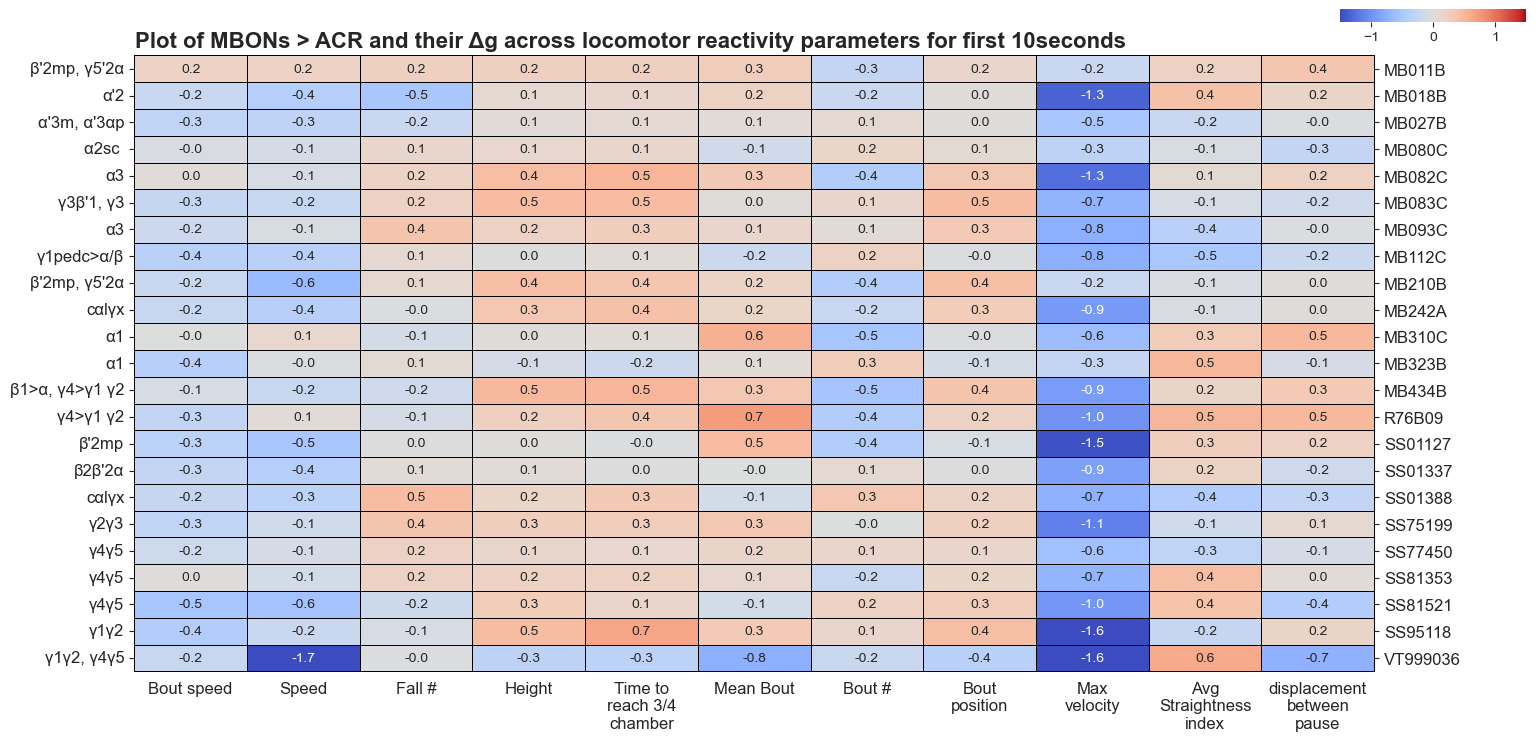

In [95]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

dfreglobe = dfreg_10seconds.copy()
dfreglobe['Lobe'] = lobelocation['Lobe_location']
dfreglobe['Name'] = lobelocation['MBON number']
df00 = dfreglobe.copy()

df50 = df00.set_index(['Lobe'])
df50 = df50.drop(['MBON', 'Name'], axis =1)
fig1, ax3 = plt.subplots(figsize=(16, 8))     
#colorbar
cax = inset_axes(ax3,
                 width="15%",  # width: 40% of parent_bbox width
                 height="2%",  # height: 10% of parent_bbox height
                 loc='lower right',
                 bbox_to_anchor=(0.1, 1.1, 1, 1),
                 bbox_transform=ax3.transAxes,
                 borderpad=-2,
                 )
sns.set_style("whitegrid", {'axes.grid' : False})           
j7 = sns.heatmap(df50, ax = ax3, annot=True, fmt=".1f", vmin = -1.5, vmax = 1.5, cmap='coolwarm', linewidths=0.5, linecolor='black'
                 , clip_on=False,  cbar_ax=cax, cbar_kws = dict(orientation = "horizontal")) #use_gridspec=False,location="bottom", shrink = 0.25, pad=0.01
j7.set_ylabel('')
j7.set_yticklabels(j7.get_yticklabels(), va='center', rotation = 0, fontsize = 12)
j7.set_xticklabels(j7.get_xticklabels(), rotation = 0, fontsize = 12)

#secondary axes
j8 = j7.twinx()
j8.set_ylim([0,j7.get_ylim()[0]])
j8.set_yticks(j7.get_yticks())

j8.set_yticklabels(df00['MBON'].iloc[::-1], fontsize=12)
j8.spines['top'].set_visible(False)
j8.spines['right'].set_visible(False)
j8.spines['bottom'].set_visible(False)
j8.spines['left'].set_visible(False)


wrap_labels(j7, 10)
j7.set_title('Plot of MBONs > ' + responder + ' and their Δg across locomotor reactivity parameters for first 10seconds', x=0.4, weight='bold', fontsize =16 )

# #fig1.tight_layout()

plt.savefig(openPath + "images\\" + date + "_" + responder + "_deltagheatmapwithlobelocations_forfirst10s.png", dpi = 1200)

## lobe locations

In [ ]:
newfile = openPath + "Compilation with delta\\fivesecondrule\\"
files = os.listdir(newfile)

for y in files:
    if responder in y:
        name = y.split(" ")[1]
        newfileread = pd.read_csv(newfile + y)
        globals()[name] = (newfileread.set_index("MBON"))
        
secondrule = "20seconds"

if "ten" in newfile:
    secondrule = "10seconds"
if "eight" in newfile:
    secondrule = "8seconds"
if "five" in newfile:
    secondrule = "5seconds"
    
directorynew = os.path.dirname(os.path.dirname(openPath)) #goes up one directory
fileinnewdirc = os.listdir(directorynew)

for file_no2 in fileinnewdirc:
    if ".csv" in file_no2:
        ff = os.path.join(directorynew, file_no2)
        csvfile = pd.read_csv(ff)

csvfile = csvfile.astype('string')

for n, k in zip(["B", "y", "a"], ['β', "γ", "α"]):
    csvfile['Lobe'] = csvfile['Lobe'].str.replace(n, k)


In [61]:
def find_number(df, lookup_value, genre):
    lobe_values = []
    for _, row in df.iterrows():
        # Splitting the 'MBON' values and removing any potential whitespace
        mbon_values = [x.strip() for x in row['MBON names'].split(',')]
        if lookup_value in mbon_values:
            lobe_values.append(row[genre])
            
    lobelobe = list(set(lobe_values))
    return ', '.join(lobelobe)

In [62]:
lobelocation = pd.DataFrame()

for m in dblist.index.tolist():
    lobeloc = pd.DataFrame()
    unqlist = []
    lobeloc['MBON'] = [m]
    loclst = find_number(csvfile, m, "Lobe")
    mbonlst = find_number(csvfile, m, "MBON number")
    ntlst = find_number(csvfile, m, "Neurotransmitter")
    lobeloc['Lobe_location'] = [loclst]
    lobeloc['MBON number'] = [mbonlst]
    lobeloc['Neurotransmitter'] = [ntlst]
    
    lobelocation = pd.concat([lobelocation, lobeloc])

lobelocation = lobelocation.reset_index(drop=True)


## heatmap df generation

In [63]:
import textwrap

def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

In [64]:
#delta g only
#dblist = dblist.set_index("MBON")

import scikits.bootstrap as skb
dfreg2 = pd.DataFrame()
for n in list(dblist.index):
    dfreg = pd.DataFrame()
    dfreg["Bout speed"] = dfreg_bspeed[dfreg_bspeed.index == n]['delta_g']
    dfreg["Speed"] = dfreg_speed[dfreg_speed.index == n]['delta_g']
    dfreg["Fall #"] = dfreg_fall[dfreg_fall.index == n]['delta_g']
    dfreg["Height"] = dfreg_height[dfreg_height.index == n]['delta_g']
    dfreg["Time to reach 3/4 chamber"] = dfreg_time[dfreg_time.index == n]['delta_g']
    # dfreg["Mean\n Pause"] = dfreg_meanpause[dfreg_meanpause.index == n]['delta_g']
    # dfreg["Pause #"] = dfreg_pause[dfreg_pause.index == n]['delta_g']
    dfreg["Mean Bout"] = dfreg_meanbout[dfreg_meanbout.index == n]['delta_g']
    dfreg["Bout #"] = dfreg_bout[dfreg_bout.index == n]['delta_g']
    dfreg["Bout position"] = dfreg_boutpos[dfreg_boutpos.index == n]['delta_g']
    # dfreg["Pause\n position"] = dfreg_pausepos[dfreg_pausepos.index == n]['delta_g']
    #new features
    dfreg["Max velocity"] = dfreg_maxvelocity[dfreg_maxvelocity.index == n]['delta_g']
    dfreg["Avg Straightness index"] = dfreg_straightindex[dfreg_straightindex.index == n]['delta_g']
    dfreg["displacement between pause"] = dfreg_displacementbetweenpause[dfreg_displacementbetweenpause.index == n]['delta_g']
    dfreg['MBON'] = n
    dfreg2 = pd.concat([dfreg2, dfreg], axis = 0).reset_index(drop=True)

#dfreg2['Lobe'] = lobelocation['Lobe_location']

## scatter plot clustering

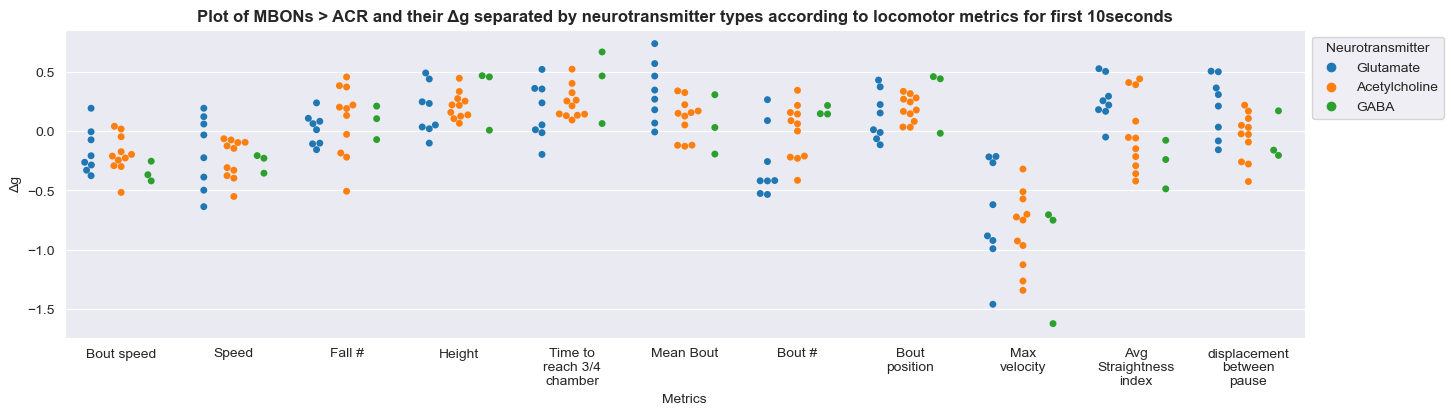

In [ ]:
dfreglobe = dfreg2.copy()
dfreglobe['Lobe'] = lobelocation['Lobe_location']
dfreglobe['Name'] = lobelocation['MBON number']
dfreglobe['Neurotransmitter'] = lobelocation['Neurotransmitter']

df00 = dfreglobe.copy()
novt = df00[(df00['MBON']== "VT999036")].index
df50 = df00.drop(novt)
df50 = df50.drop(['MBON', 'Name', 'Lobe'], axis =1)

fig, axes = plt.subplots(figsize=(16,4))

df89 = pd.melt(df50, id_vars = ['Neurotransmitter'], var_name = 'Metrics', value_name = "Δg")
g1 = sns.swarmplot(data=df89, x= 'Metrics', y = 'Δg', hue='Neurotransmitter',dodge = True)
sns.move_legend(g1, "upper left", bbox_to_anchor=(1, 1))
sns.set_style("darkgrid")
wrap_labels(axes, 10)
g1.set_title('Plot of MBONs > ' + responder + ' and their Δg separated by neurotransmitter types according to locomotor metrics for first ' + secondrule, weight='bold', fontsize =12 )

#plt.savefig(openPath + "images\\" + date + "_" + responder + "_separationbyNTtypes_" + secondrule +".png", dpi = 1200, bbox_inches='tight')

## sns paired plot

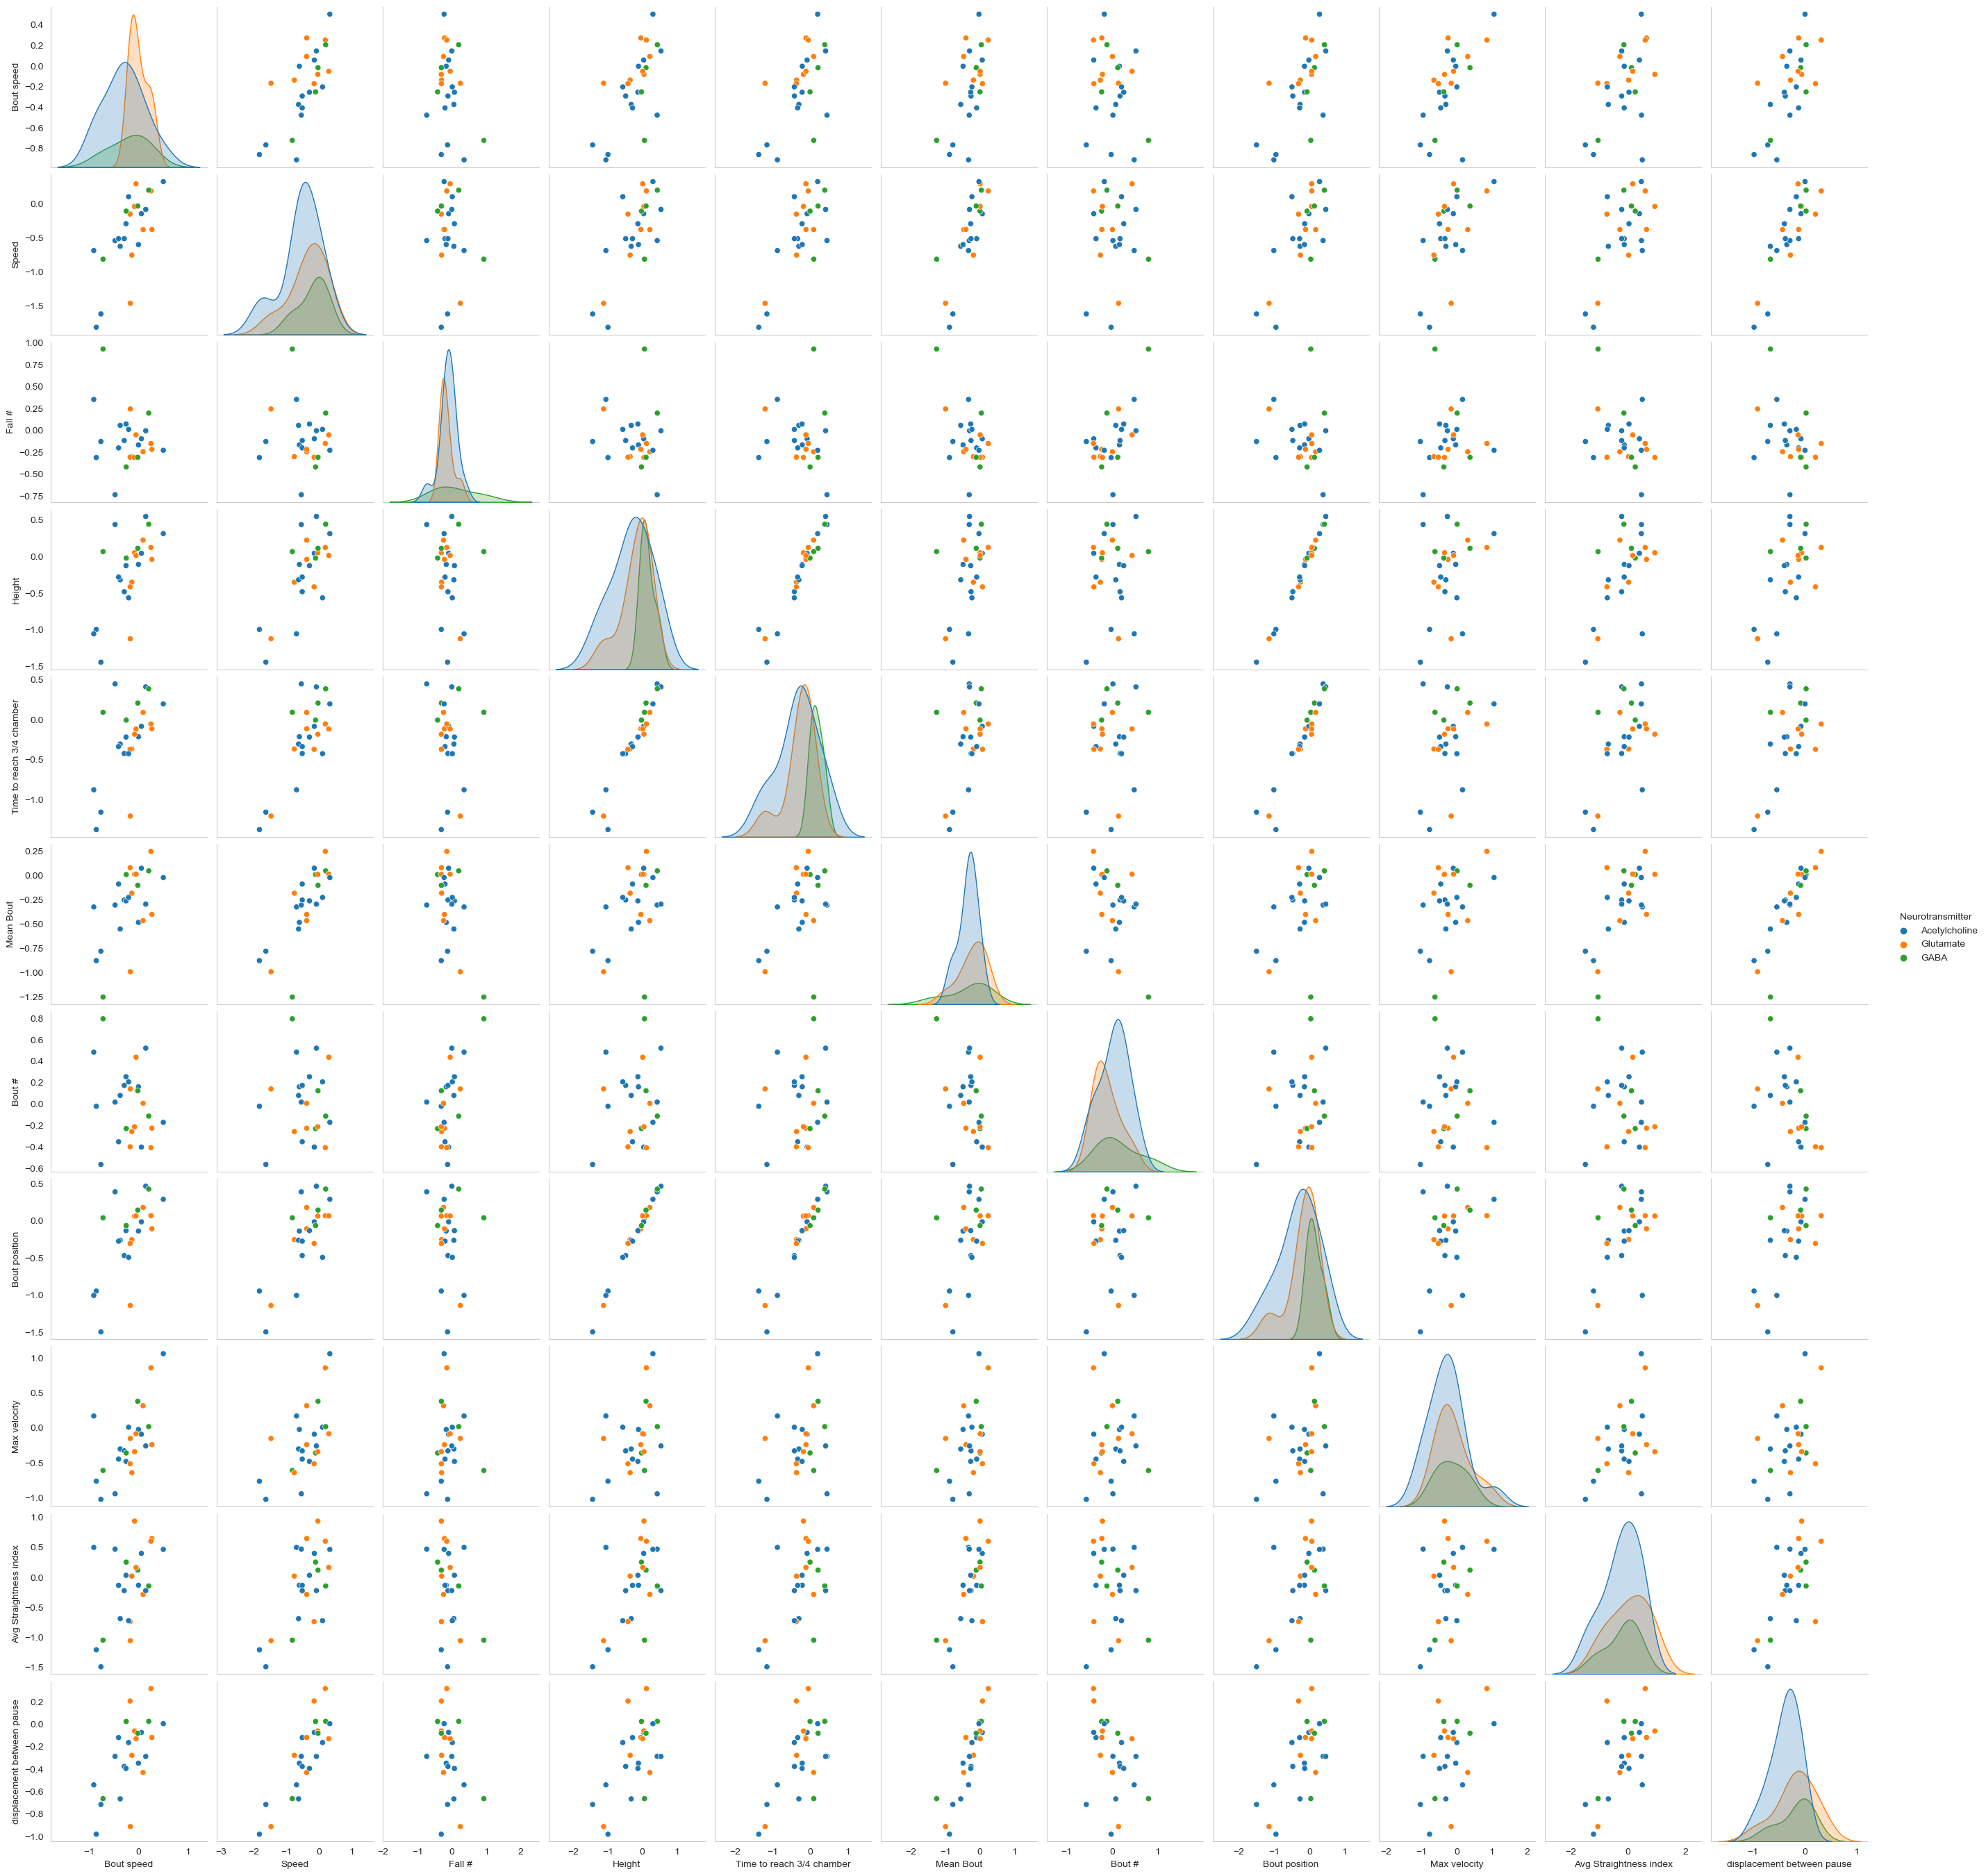

In [58]:
dfreglobe = dfreg2.copy()
dfreglobe['Lobe'] = lobelocation['Lobe_location']
dfreglobe['Name'] = lobelocation['MBON number']
dfreglobe['Neurotransmitter'] = lobelocation['Neurotransmitter']

df00 = dfreglobe.copy()
novt = df00[(df00['MBON']== "VT999036")].index
df50 = df00.drop(novt)
df50 = df50.drop(['MBON', 'Name', 'Lobe'], axis =1)

t1 = sns.pairplot(data=df50, hue='Neurotransmitter')
#t1.set_title('MBONs > ' + responder, weight='bold', fontsize =12 )

plt.savefig(openPath + "images\\" + date + "_" + responder + "_separationbyNTtypes_" + secondrule +".png", dpi = 1200, bbox_inches='tight')

## clustermap

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

dfreglobe = dfreg2.copy()
dfreglobe['Lobe'] = lobelocation['Lobe_location']
dfreglobe['Name'] = lobelocation['MBON number']
dfreglobe['Neurotransmitter'] = lobelocation['Neurotransmitter']

df00 = dfreglobe.copy()

df50 = df00.set_index(['Neurotransmitter'])
df50 = df50.drop(['MBON', 'Name', 'Lobe'], axis =1)
methodlist = ['average', 'single']
metriclist = ['euclidean', 'correlation']

for methodd in methodlist:
    for metricc in metriclist:
        print (methodd + " " + metricc)
        j7 = sns.clustermap(df50, cmap='coolwarm', metric = metricc, method = methodd,vmin = -1.5, vmax=1.5, 
                            cbar_kws = dict(shrink = 0.2, ticks = [-1.5, 1.5]), figsize=(10, 10), cbar_pos=(0, .2, .02, .1) ) #use_gridspec=False,location="bottom", shrink = 0.25, pad=0.01
        ax = j7.ax_heatmap
        ax.set_ylabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 9)
        wrap_labels(ax, 8)
        j7.fig.suptitle('Clustermap using ' + methodd + "_" + metricc + ' :MBONs > ' + responder + ' and their Δg for first ' + secondrule, weight='bold', fontsize =12, y =1.0)
        
        plt.savefig(openPath + "images\\" + date + "_" + responder + "_clustermap_" + methodd + "_" + metricc + "_" + secondrule +".png", dpi = 1200)

## heatmap

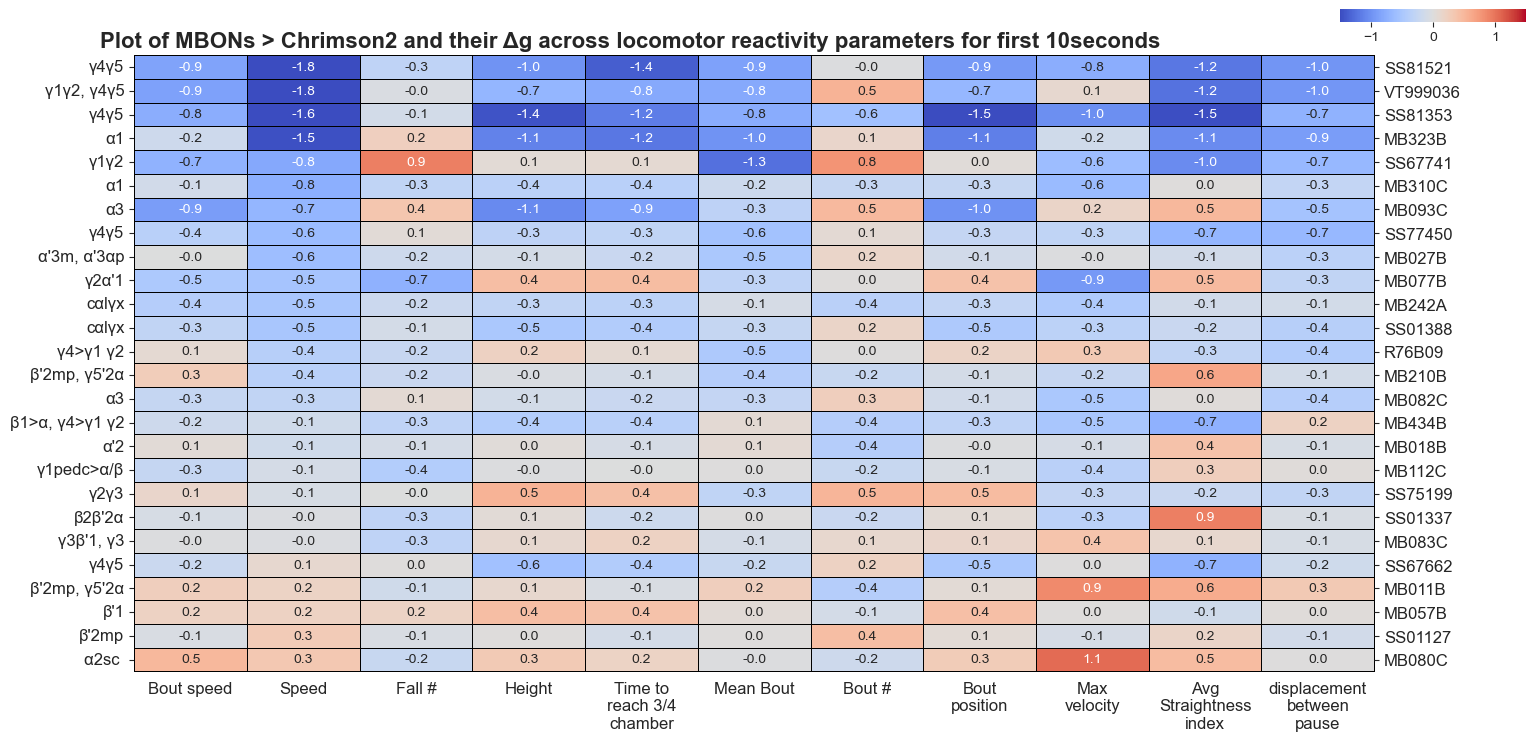

In [65]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

dfreglobe = dfreg2.copy()
dfreglobe['Lobe'] = lobelocation['Lobe_location']
dfreglobe['Name'] = lobelocation['MBON number']
df00 = dfreglobe.copy()

df50 = df00.set_index(['Lobe'])
df50 = df50.drop(['MBON', 'Name'], axis =1)
fig1, ax3 = plt.subplots(figsize=(16, 8))     
#colorbar
cax = inset_axes(ax3,
                 width="15%",  # width: 40% of parent_bbox width
                 height="2%",  # height: 10% of parent_bbox height
                 loc='lower right',
                 bbox_to_anchor=(0.1, 1.1, 1, 1),
                 bbox_transform=ax3.transAxes,
                 borderpad=-2,
                 )
sns.set_style("whitegrid", {'axes.grid' : False})           
j7 = sns.heatmap(df50, ax = ax3, annot=True, fmt=".1f", vmin = -1.5, vmax = 1.5, cmap='coolwarm', linewidths=0.5, linecolor='black'
                 , clip_on=False,  cbar_ax=cax, cbar_kws = dict(orientation = "horizontal")) #use_gridspec=False,location="bottom", shrink = 0.25, pad=0.01
j7.set_ylabel('')
j7.set_yticklabels(j7.get_yticklabels(), va='center', rotation = 0, fontsize = 12)
j7.set_xticklabels(j7.get_xticklabels(), rotation = 0, fontsize = 12)

#secondary axes
j8 = j7.twinx()
j8.set_ylim([0,j7.get_ylim()[0]])
j8.set_yticks(j7.get_yticks())

j8.set_yticklabels(df00['MBON'].iloc[::-1], fontsize=12)
j8.spines['top'].set_visible(False)
j8.spines['right'].set_visible(False)
j8.spines['bottom'].set_visible(False)
j8.spines['left'].set_visible(False)


wrap_labels(j7, 10)
j7.set_title('Plot of MBONs > ' + responder + ' and their Δg across locomotor reactivity parameters for first ' + secondrule, x=0.4, weight='bold', fontsize =16 )

#fig1.tight_layout()

plt.savefig(openPath + "images\\" + date + "_" + responder + "_deltagheatmapwithlobelocations_" + secondrule +".png", dpi = 1200)

## simple heatmap version + delta version

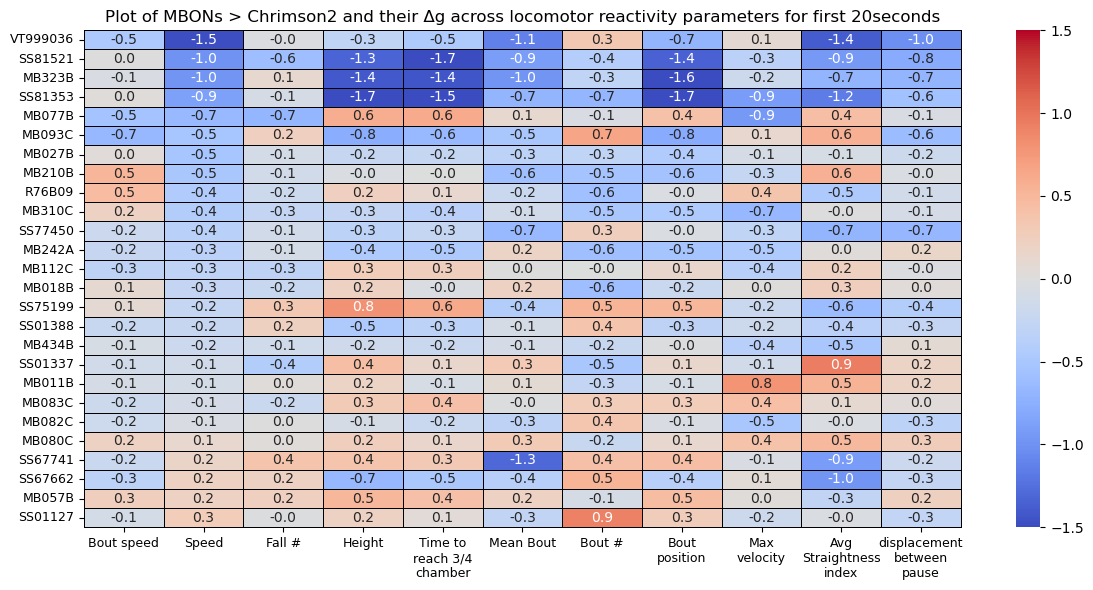

In [ ]:
#simple heatmap
# 
df5 = dfreg2.set_index(['MBON'])
fig, ax1 = plt.subplots(figsize=(12, 6))                
g1 = sns.heatmap(df5, annot=True, fmt=".1f", vmin = -1.5, vmax = 1.5, cmap='coolwarm', linewidths=0.5, linecolor='black', clip_on=False)
g1.set_ylabel('')
g1.set_yticklabels(g1.get_yticklabels(), rotation = 0, fontsize = 9)
g1.set_xticklabels(g1.get_xticklabels(), rotation = 0, fontsize = 9)
wrap_labels(g1, 10)
ax1.set_title('Plot of MBONs > ' + responder + ' and their Δg across locomotor reactivity parameters for first ' + secondrule)
fig.tight_layout()
#plt.savefig(openPath + "images\\" + date + "_" + responder + "_deltagheatmap_" + secondrule +".png", dpi = 1200)

In [ ]:
#delta and delta g heatmap
# 
dfreglist = [dfreg_bspeed.loc[dblist.index], dfreg_speed.loc[dblist.index], dfreg_fall.loc[dblist.index],dfreg_height.loc[dblist.index], dfreg_meanbout.loc[dblist.index], dfreg_bout.loc[dblist.index],dfreg_boutpos.loc[dblist.index], dfreg_maxvelocity.loc[dblist.index],dfreg_straightindex.loc[dblist.index], dfreg_displacementbetweenpause.loc[dblist.index]]
totalregdf = pd.DataFrame()

for n,k in zip(dfreg2.columns[:-1], dfreglist):
    k.columns = pd.MultiIndex.from_product([[n], k.columns.tolist()])
    totalregdf = pd.concat([totalregdf, k], axis =1)


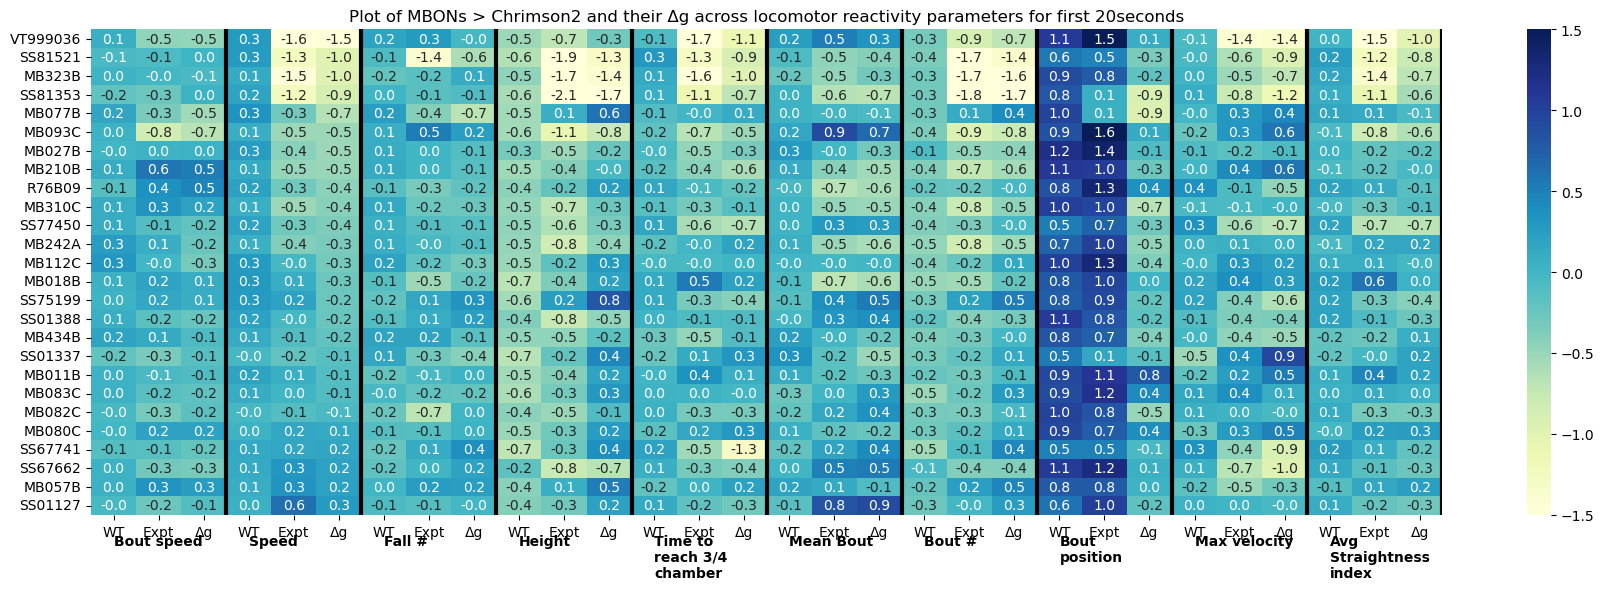

In [ ]:
from textwrap import wrap

df0 = totalregdf.copy()
fig, ax2 = plt.subplots(figsize=(18, 6))                

first_row_headers = df0.columns.get_level_values(0)
unique_first_row_headers = first_row_headers.unique()
firstlabels = [ ' \n '.join(wrap(l, 12)) for l in unique_first_row_headers]

second_row_headers = df0.columns.get_level_values(1)
second_headers = [l.replace('delta_', 'Δ') for l in second_row_headers.tolist()]

y3 = sns.heatmap(df0, annot=True, fmt=".1f", vmin = -1.5, vmax = 1.5, cmap='YlGnBu',clip_on=False) # linewidths=0.5, linecolor='black', 
y3.set_ylabel('')
# Calculate the positions for the primary x-tick labels (center of each cell)
tick_positions = [i + 0.5 for i in range(len(second_headers))]

# Set the primary x-axis labels (second row headers)
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(second_headers, rotation=0)

#Add the unique first row headers as additional labels
for label in unique_first_row_headers:
    # Find the positions for this label
    positions = [i for i, x in enumerate(first_row_headers) if x == label]

    # Calculate the center position of these columns
    center_position = positions[0]
    
    newlabel = textwrap.fill(label, 12)
    
    # Place the label with adjusted vertical position
    ax2.text(center_position+0.5, len(second_headers)-3, newlabel, ha='left', va='top', rotation=0, weight='bold')
    #wrap_labels(ax2, 10)
    
# Remove x-ax2is label
ax2.set_xlabel("")

ax2.set_title('Plot of MBONs > ' + responder + ' and their Δg across locomotor reactivity parameters for first ' + secondrule)
ax2.vlines(list(range(3,3*12,3)), *ax2.get_xlim(), linewidth=3, color='k')


fig.tight_layout()

#plt.savefig(openPath + "images\\" + date + "_" + responder + "_cohens d and delta gheatmap_" + secondrule +".png", dpi = 1200)

